In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, desc

In [37]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()

In [39]:
# reflect the tables
Base.prepare(engine,reflect=True)

In [40]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [41]:
# Save references to each table
Station = Base.classes.station

Measurment = Base.classes.measurement

In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [43]:
# Display the row's columns and data in dictionary format
first_row_stat = session.query(Station).first()
first_row_meas = session.query(Measurment).first()

# show columns
print(first_row_stat.__dict__.keys())
print(first_row_meas.__dict__.keys())

dict_keys(['_sa_instance_state', 'id', 'name', 'longitude', 'station', 'latitude', 'elevation'])
dict_keys(['_sa_instance_state', 'prcp', 'id', 'date', 'tobs', 'station'])


# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
session.query(func.max(Measurment.date)).all()

maxdate = session.query(func.max(Measurment.date)).first()
print(maxdate)
maxdate = maxdate[0]
print(maxdate)

('2017-08-23',)
2017-08-23


2017-08-23 00:00:00
2016-08-22 00:00:00


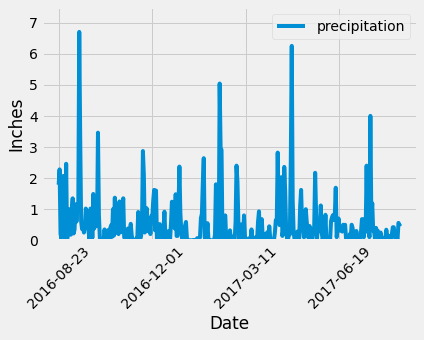

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta
max_date = '08-23-17'
start_date = datetime.strptime(max_date,'%m-%d-%y')
print(start_date)

# Calculate the date one year from the last date in data set.
one_year = start_date + timedelta(days=-366)
print(one_year)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurment.date,func.max(Measurment.prcp)).group_by(Measurment.date).filter(Measurment.date>one_year).distinct().all()
results

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,columns=['date','prcp'])
df.columns=['date','precipitation']
df = df.set_index('date')

# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(xlabel='Date',ylabel='Inches',use_index=True,rot=45,ylim=(0,7.5))
plt.legend(loc='upper right')

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).distinct().count()

9

In [48]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Station.id, Station.name, Station.station, Measurment.id, Measurment.station]


session.query(Station.id,Station.station,Station.name,func.count(Measurment.station)).filter(Station.station == Measurment.station).\
    group_by(Station.id,Station.station,Station.name).order_by(desc(func.count(Measurment.station))).all()


[(7, 'USC00519281', 'WAIHEE 837.5, HI US', 2772),
 (1, 'USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 2709),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 (4, 'USC00517948', 'PEARL CITY, HI US', 1372),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [49]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Station.id,Station.station,Station.name,func.count(Measurment.station)).filter(Station.station == Measurment.station).\
    group_by(Station.id,Station.station,Station.name).order_by(desc(func.count(Measurment.station))).all()[0][0]

active_stat_name =  session.query(Station.id,Station.station,Station.name,func.count(Measurment.station)).filter(Station.station == Measurment.station).\
    group_by(Station.id,Station.station,Station.name).order_by(desc(func.count(Measurment.station))).all()[0][2]

print(f"The Most Active Station Is: Station {most_active_station} - {active_stat_name}")

low_temp = session.query(func.min(Measurment.tobs)).filter(Station.station == Measurment.station and Station.id==most_active_station).all()[0][0]
print(f"Low Temp: {low_temp}")

hi_temp = session.query(func.max(Measurment.tobs)).filter(Station.station == Measurment.station and Station.id==most_active_station).all()[0][0]
print(f"High Temp: {hi_temp}")

avg_temp = session.query(func.avg(Measurment.tobs)).filter(Station.station == Measurment.station and Station.id==most_active_station).all()[0][0]
print(f"Averageg Temp: {avg_temp}")


The Most Active Station Is: Station 7 - WAIHEE 837.5, HI US
Low Temp: 53.0
High Temp: 87.0
Averageg Temp: 73.09795396419437


In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


results2 = session.query(Measurment.date,Measurment.tobs).group_by(Measurment.date)\
    .filter(Station.station == Measurment.station)\
    .filter(Station.id==7)\
    .filter(Measurment.date>one_year)\
    .distinct().all()
#print(results2)

df2 = pd.DataFrame(results2,columns=['date','tobs'])
df2.columns=['date','temp observation']
df2 = df2.set_index('date')

df2

,temp observation
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


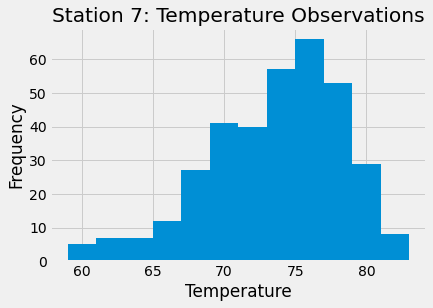

In [51]:
ax = df2.hist(bins=12)
ax = ax[0]

for x in ax:
    x.set_ylabel("Frequency")
    x.set_xlabel("Temperature")
    x.set_title("Station 7: Temperature Observations")


# Close session

In [52]:
# Close Session
session.close()